In this notebook we try to predict fumigation status using the microbiome data.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

We first try group into family level and use xgboost to predict fumigation status.

In [2]:
# read in data
df_abundance = pd.read_csv('bac_abundance.csv')
metadata = pd.read_csv("samp_metadata.csv")

In [3]:
# replace unknown family with genus
for i, row in enumerate(df_abundance.itertuples()):
    if row.Family == "Unknown_Family":
        df_abundance.at[i, "Family"] = row.Genus

In [4]:
df_abundance.drop(columns=['Unnamed: 0'], inplace=True)
df_family = df_abundance.groupby('Family').sum()
# remove columns that is not start with "Samp"
df_family = df_family[df_family.columns[df_family.columns.str.startswith('Samp')]]
df_family.head()

,Samp001,Samp002,Samp003,Samp004,Samp005,Samp006,Samp007,Samp008,Samp009,Samp010,...,Samp231,Samp232,Samp233,Samp234,Samp235,Samp236,Samp237,Samp238,Samp239,Samp240
Family,,,,,,,,,,,,,,,,,,,,,
01D2Z36,1,0,0,0,0,0,0,0,2,0,...,17,1,6,3,4,7,4,5,1,5
0319-6G20,4,0,4,5,4,0,10,3,3,8,...,15,10,19,8,20,30,18,16,28,27
053A03-B-DI-P58,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
27F-1492R,0,0,1,0,0,0,1,1,0,0,...,0,0,0,3,1,6,1,1,3,1
37-13,4,0,3,2,0,2,6,3,0,7,...,15,8,20,8,9,20,6,28,11,15


In [5]:
metadata.drop(columns=['Unnamed: 0'], inplace=True)
metadata.head()

,Samp,samp_number,Time,Treatment,Date
0,Fum-1-1,1,Day_0,Non-amended,2016-08-08
1,Fum-1-2,2,Day_0,Non-amended,2016-08-08
2,Fum-1-3,3,Day_0,Non-amended,2016-08-08
3,Fum-1-4,4,Day_0,Non-amended,2016-08-08
4,Fum-1-5,5,Day_0,Non-amended,2016-08-08


In [6]:
# 0 = non-fumigated, 1 = recently fumigated, 2 = fumigated more than a month ago
metadata["Fumigation"] = None

for i, row in enumerate(metadata.itertuples()):
    if row.Time == "Day_0" or row.Treatment == "Non-fumigated chipping grass":
        metadata.at[i, "Fumigation"] = 0
    elif row.Time == "Day_10" and row.Treatment != "Non-fumigated chipping grass":
        metadata.at[i, "Fumigation"] = 1
    else:
        metadata.at[i, "Fumigation"] = 2

metadata


,Samp,samp_number,Time,Treatment,Date,Fumigation
0,Fum-1-1,1,Day_0,Non-amended,2016-08-08,0
1,Fum-1-2,2,Day_0,Non-amended,2016-08-08,0
2,Fum-1-3,3,Day_0,Non-amended,2016-08-08,0
3,Fum-1-4,4,Day_0,Non-amended,2016-08-08,0
4,Fum-1-5,5,Day_0,Non-amended,2016-08-08,0
...,...,...,...,...,...,...
235,Fum-1-236,236,Day_282,Non-fumigated chipping grass,2017-05-17,0
236,Fum-1-237,237,Day_282,Non-fumigated chipping grass,2017-05-17,0
237,Fum-1-238,238,Day_282,Non-fumigated chipping grass,2017-05-17,0
238,Fum-1-239,239,Day_282,Non-fumigated chipping grass,2017-05-17,0


In [7]:
# Get X and y
X = df_family.T.values
y = metadata["Fumigation"].values.astype(int)

In [8]:
# import more libraries
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from xgboost import XGBClassifier

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# create model
model_fam_XGB = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# cv
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=40, random_state=42)
scores = cross_val_score(model_fam_XGB, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

# Print the mean and standard deviation of the scores
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.p

Cross-validated Accuracy: 0.99 (+/- 0.04)


In [9]:
# test model
model_fam_XGB.fit(X_train, y_train)
y_pred = model_fam_XGB.predict(X_test)
test_score_fam_XGB = model_fam_XGB.score(X_test, y_test)

cm_XGB_fam = confusion_matrix(y_test, y_pred)
# for roc curve
# only binary class, fumigated or not, convert from 3 classes to 2 classes
y_test_binary = np.where(y_test == 0, 0, 1)
y_pred_binary = np.where(y_pred == 0, 0, 1)
y_pred_proba = model_fam_XGB.predict_proba(X_test)
fpr_XGB_fam, tpr_XGB_fam, thresholds_XGB_fam = roc_curve(y_test_binary, y_pred_proba[:,1] + y_pred_proba[:,2])
print("Test Accuracy: %0.2f" % test_score_fam_XGB)

Test Accuracy: 0.94


Now, we try using random forest to predict fumigation status.

In [10]:
# random forest
from sklearn.ensemble import RandomForestClassifier

# create model
model_fam_RF = RandomForestClassifier(random_state=42)

# cv
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=40, random_state=42)
scores = cross_val_score(model_fam_RF, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

# Print the mean and standard deviation of the scores
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross-validated Accuracy: 1.00 (+/- 0.03)


In [11]:
# test model
model_fam_RF.fit(X_train, y_train)
y_pred = model_fam_RF.predict(X_test)
test_score_fam_RF = model_fam_RF.score(X_test, y_test)
cm_RF_fam = confusion_matrix(y_test, y_pred)
# for roc curve
# only binary class, fumigated or not, convert from 3 classes to 2 classes
y_test_binary = np.where(y_test == 0, 0, 1)
y_pred_binary = np.where(y_pred == 0, 0, 1)
y_pred_proba = model_fam_RF.predict_proba(X_test)
fpr_RF_fam, tpr_RF_fam, thresholds_RF_fam = roc_curve(y_test_binary, y_pred_proba[:,1] + y_pred_proba[:,2])
print("Test Accuracy: %0.2f" % test_score_fam_RF)

Test Accuracy: 0.98


Use logistic regression to predict fumigation status.

In [12]:
# normalize data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# logistic regression
from sklearn.linear_model import LogisticRegression

# create model
model_fam_logreg = LogisticRegression(random_state=42)

# cv
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=40, random_state=42)
scores = cross_val_score(model_fam_logreg, X_train_scaled, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

# Print the mean and standard deviation of the scores
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross-validated Accuracy: 1.00 (+/- 0.02)


In [14]:
# test model
model_fam_logreg.fit(X_train_scaled, y_train)
y_pred = model_fam_logreg.predict(X_test_scaled)
test_score_fam_lr = model_fam_logreg.score(X_test_scaled, y_test)
cm_lr_fam = confusion_matrix(y_test, y_pred)
# for roc curve 
# only binary class, fumigated or not, convert from 3 classes to 2 classes
y_test_binary = np.where(y_test == 0, 0, 1)
y_pred_binary = np.where(y_pred == 0, 0, 1)
y_pred_proba = model_fam_logreg.predict_proba(X_test_scaled)
fpr_lr_fam, tpr_lr_fam, thresholds_lr_fam = roc_curve(y_test_binary, y_pred_proba[:,1] + y_pred_proba[:,2])

print("Test Accuracy: %0.2f" % test_score_fam_lr)

Test Accuracy: 0.98


In [15]:
# find important features
coefficients = model_fam_logreg.coef_[0]
feature_names = list(df_family.T.columns)

# sort features by importance
sorted_idx = np.argsort(np.abs(coefficients))[::-1]
sorted_features = [feature_names[idx] for idx in sorted_idx]
sorted_coefficients = coefficients[sorted_idx]

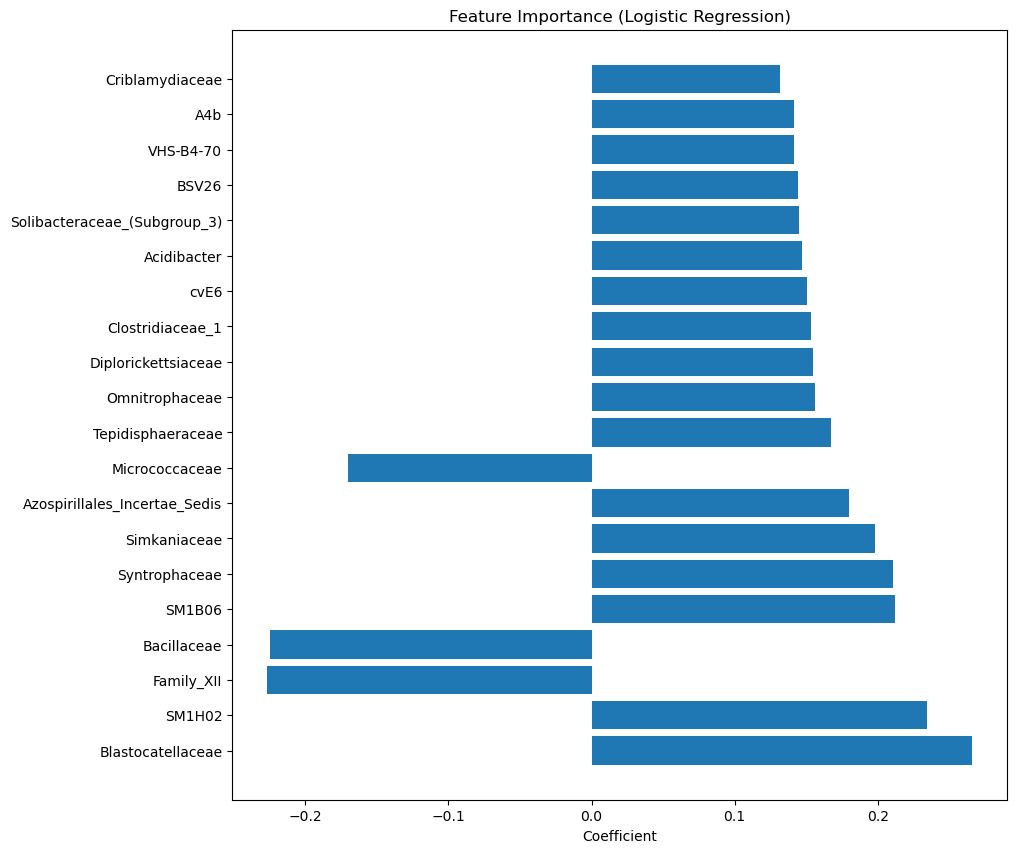

In [16]:
# plot the 20 most important features
plt.figure(figsize=(10, 10))
plt.barh(sorted_features[:20], sorted_coefficients[:20])
plt.xlabel("Coefficient")
plt.title("Feature Importance (Logistic Regression)")
plt.show()

In [17]:
# print the 20 most important features
print("Most important features: ")

for i in range(20):
    print(sorted_features[i], sorted_coefficients[i])

logreg_top20_feature_fam = sorted_features[:20]

Most important features: 
Blastocatellaceae 0.2657590822982595
SM1H02 0.2345408066009669
Family_XII -0.2265746603104429
Bacillaceae -0.22503099880574606
SM1B06 0.2119943763415729
Syntrophaceae 0.2103020443245649
Simkaniaceae 0.19788789348989205
Azospirillales_Incertae_Sedis 0.17969498144315565
Micrococcaceae -0.17036100835794724
Tepidisphaeraceae 0.16759855853211517
Omnitrophaceae 0.15621362217875748
Diplorickettsiaceae 0.1548885613492484
Clostridiaceae_1 0.15355358042797443
cvE6 0.1506766959583795
Acidibacter 0.14696897136575376
Solibacteraceae_(Subgroup_3) 0.14468476552410722
BSV26 0.1441677415750427
VHS-B4-70 0.1416678742882761
A4b 0.14131394514743992
Criblamydiaceae 0.13178222031839798


Now we determine the most important features using random forest.

In [18]:
importances = model_fam_RF.feature_importances_
sorted_idx = np.argsort(np.abs(importances))[::-1]
sorted_features = [feature_names[idx] for idx in sorted_idx]
sorted_importances = importances[sorted_idx]

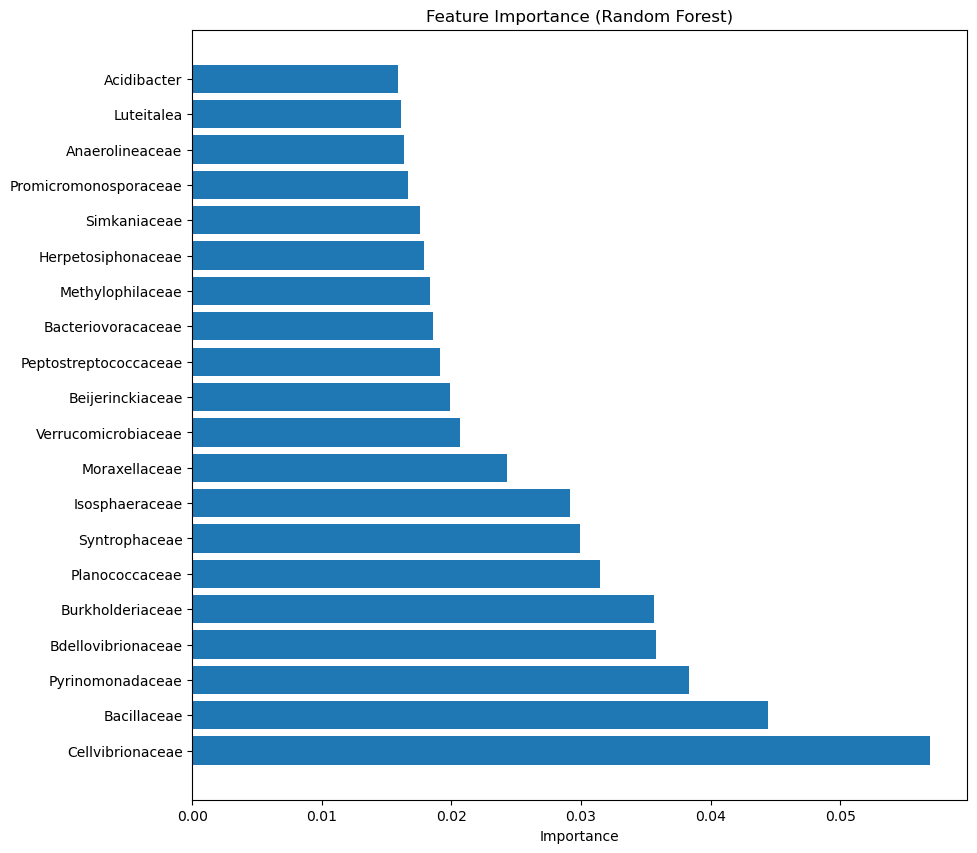

In [19]:
# plot the 20 most important features
plt.figure(figsize=(10, 10))
plt.barh(sorted_features[:20], sorted_importances[:20])
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()

In [20]:
# print the 20 most important features
print("Most important features predicted by Random Forest Classifier: ")

for i in range(20):
    print(sorted_features[i], sorted_importances[i])

RF_top20_feature_fam = sorted_features[:20]

Most important features predicted by Random Forest Classifier: 
Cellvibrionaceae 0.05696730691180294
Bacillaceae 0.0444408689198775
Pyrinomonadaceae 0.03833947508732741
Bdellovibrionaceae 0.03578374031578358
Burkholderiaceae 0.03563526260273806
Planococcaceae 0.031434680681686845
Syntrophaceae 0.02991140841963408
Isosphaeraceae 0.029137270122426805
Moraxellaceae 0.024291641750093775
Verrucomicrobiaceae 0.020649288528393296
Beijerinckiaceae 0.01986047466022437
Peptostreptococcaceae 0.01910381777707848
Bacteriovoracaceae 0.018540791861642293
Methylophilaceae 0.018326875963747123
Herpetosiphonaceae 0.01786471939304918
Simkaniaceae 0.01759828995305413
Promicromonosporaceae 0.01662674832505823
Anaerolineaceae 0.016309508965548263
Luteitalea 0.016119518025059912
Acidibacter 0.01586953742236179


Now we find the most important features using XGBoost.

In [21]:
# find important features
importances = model_fam_XGB.feature_importances_
sorted_idx = np.argsort(np.abs(importances))[::-1]
sorted_features = [feature_names[idx] for idx in sorted_idx]
sorted_importances = importances[sorted_idx]

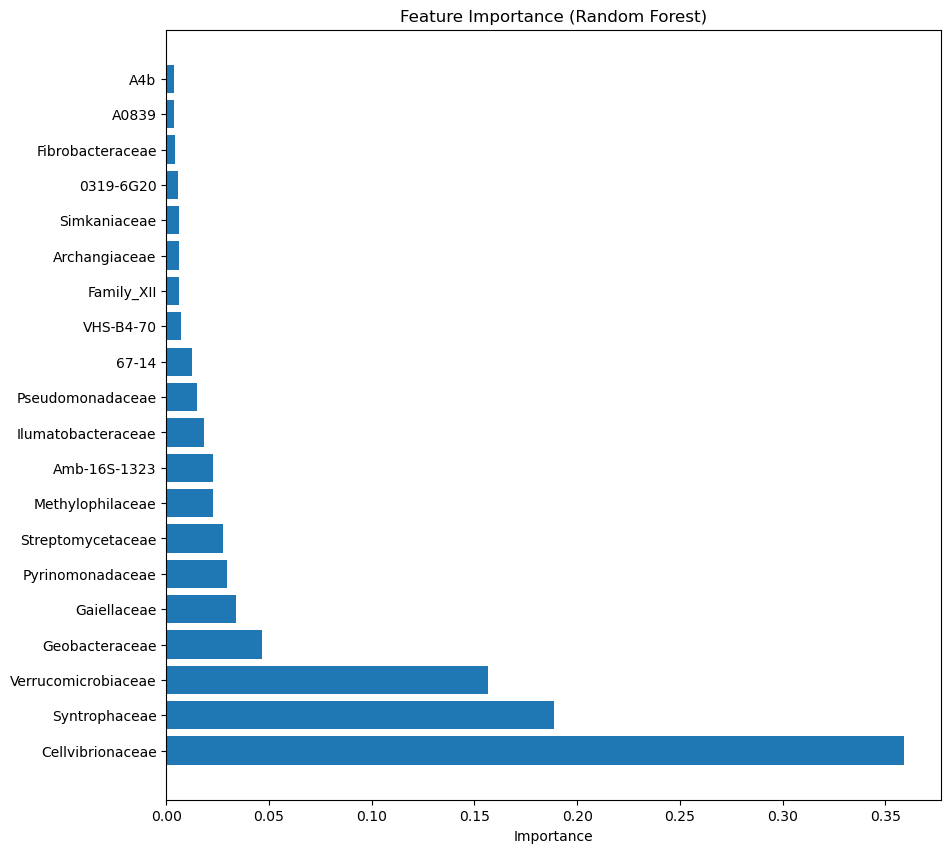

In [22]:
# plot the 20 most important features
plt.figure(figsize=(10, 10))
plt.barh(sorted_features[:20], sorted_importances[:20])
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()

In [23]:
# print the 20 most important features
print("Most important features predicted by XGBoost Classifier: ")

for i in range(20):
    print(sorted_features[i], sorted_importances[i])

XGB_top20_feature_fam = sorted_features[:20]

Most important features predicted by XGBoost Classifier: 
Cellvibrionaceae 0.3593124
Syntrophaceae 0.18878607
Verrucomicrobiaceae 0.15639809
Geobacteraceae 0.046633344
Gaiellaceae 0.03395446
Pyrinomonadaceae 0.029743453
Streptomycetaceae 0.02775511
Methylophilaceae 0.022759613
Amb-16S-1323 0.022590995
Ilumatobacteraceae 0.018406251
Pseudomonadaceae 0.01493862
67-14 0.01230223
VHS-B4-70 0.0072924234
Family_XII 0.0063464176
Archangiaceae 0.006087268
Simkaniaceae 0.0060294275
0319-6G20 0.0057037724
Fibrobacteraceae 0.0041549164
A0839 0.003779776
A4b 0.0036874437


In [24]:
# find common features
common_features = []
for feature in logreg_top20_feature_fam:
    if feature in RF_top20_feature_fam and feature in XGB_top20_feature_fam:
        common_features.append(feature)

print("Common features: ", common_features)

Common features:  ['Syntrophaceae', 'Simkaniaceae']


It can be seen that the most important features are different for random forest and XGBoost and logistic regression.

## Genus Level

Now we group the data into genus level. We see the model performance and the most important features.

In [25]:
## create genus level data
df_genus = df_abundance.groupby('Genus').sum()
# remove columns that is not start with "Samp"
df_genus = df_genus[df_genus.columns[df_genus.columns.str.startswith('Samp')]]
len(df_genus)

690

In [26]:
# Get X and y
X = df_genus.T.values
y = metadata["Fumigation"].values.astype(int)

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# check how many data enries we have
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (192, 690)
Shape of X_test:  (48, 690)
Shape of y_train:  (192,)
Shape of y_test:  (48,)


In [27]:
# create model
model_genus_XGB = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# cv
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=40, random_state=42)
scores = cross_val_score(model_genus_XGB, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

# Print the mean and standard deviation of the scores
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.p

Cross-validated Accuracy: 0.98 (+/- 0.04)


In [28]:
# test model
model_genus_XGB.fit(X_train, y_train)
y_pred = model_genus_XGB.predict(X_test)

test_score_genus_XGB = model_genus_XGB.score(X_test, y_test)
cm_XGB_genus = confusion_matrix(y_test, y_pred)
# for roc curve
# only binary class, fumigated or not, convert from 3 classes to 2 classes
y_test_binary = np.where(y_test == 0, 0, 1)
y_pred_binary = np.where(y_pred == 0, 0, 1)
y_pred_proba = model_genus_XGB.predict_proba(X_test)
fpr_XGB_genus, tpr_XGB_genus, thresholds_XGB_genus = roc_curve(y_test_binary, y_pred_proba[:,1] + y_pred_proba[:,2])

print("Test Accuracy: %0.2f" % test_score_genus_XGB)

Test Accuracy: 0.98


In [29]:
# create model
model_genus_RF = RandomForestClassifier(random_state=42)

# cv
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=40, random_state=42)
scores = cross_val_score(model_genus_RF, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

# Print the mean and standard deviation of the scores
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross-validated Accuracy: 0.99 (+/- 0.03)


In [30]:
# test model
model_genus_RF.fit(X_train, y_train)
y_pred = model_genus_RF.predict(X_test)

test_score_genus_RF = model_genus_RF.score(X_test, y_test)
cm_RF_genus = confusion_matrix(y_test, y_pred)
# for roc curve
# only binary class, fumigated or not, convert from 3 classes to 2 classes
y_test_binary = np.where(y_test == 0, 0, 1)
y_pred_binary = np.where(y_pred == 0, 0, 1)
y_pred_proba = model_genus_RF.predict_proba(X_test)
fpr_RF_genus, tpr_RF_genus, thresholds_RF_genus = roc_curve(y_test_binary, y_pred_proba[:,1] + y_pred_proba[:,2])

print("Test Accuracy: %0.2f" % test_score_genus_RF)

Test Accuracy: 0.98


In [31]:
# normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# create model
model_genus_logreg = LogisticRegression(random_state=42)

# cv
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=40, random_state=42)

scores = cross_val_score(model_genus_logreg, X_train_scaled, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

# Print the mean and standard deviation of the scores 
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross-validated Accuracy: 0.99 (+/- 0.03)


In [32]:
# test model
model_genus_logreg.fit(X_train_scaled, y_train)
y_pred = model_genus_logreg.predict(X_test_scaled)

test_score_genus_lr = model_genus_logreg.score(X_test_scaled, y_test)
cm_lr_genus = confusion_matrix(y_test, y_pred)
# for roc curve
# only binary class, fumigated or not, convert from 3 classes to 2 classes
y_test_binary = np.where(y_test == 0, 0, 1)
y_pred_binary = np.where(y_pred == 0, 0, 1)
y_pred_proba = model_genus_logreg.predict_proba(X_test_scaled)
fpr_lr_genus, tpr_lr_genus, thresholds_lr_genus = roc_curve(y_test_binary, y_pred_proba[:,1] + y_pred_proba[:,2])

print("Test Accuracy: %0.2f" % test_score_genus_lr)

Test Accuracy: 0.98


In [33]:
# find important features
coefficients = model_genus_logreg.coef_[0]
feature_names = list(df_genus.T.columns)

# sort features by importance
sorted_idx = np.argsort(np.abs(coefficients))[::-1]
sorted_features = [feature_names[idx] for idx in sorted_idx]
sorted_coefficients = coefficients[sorted_idx]

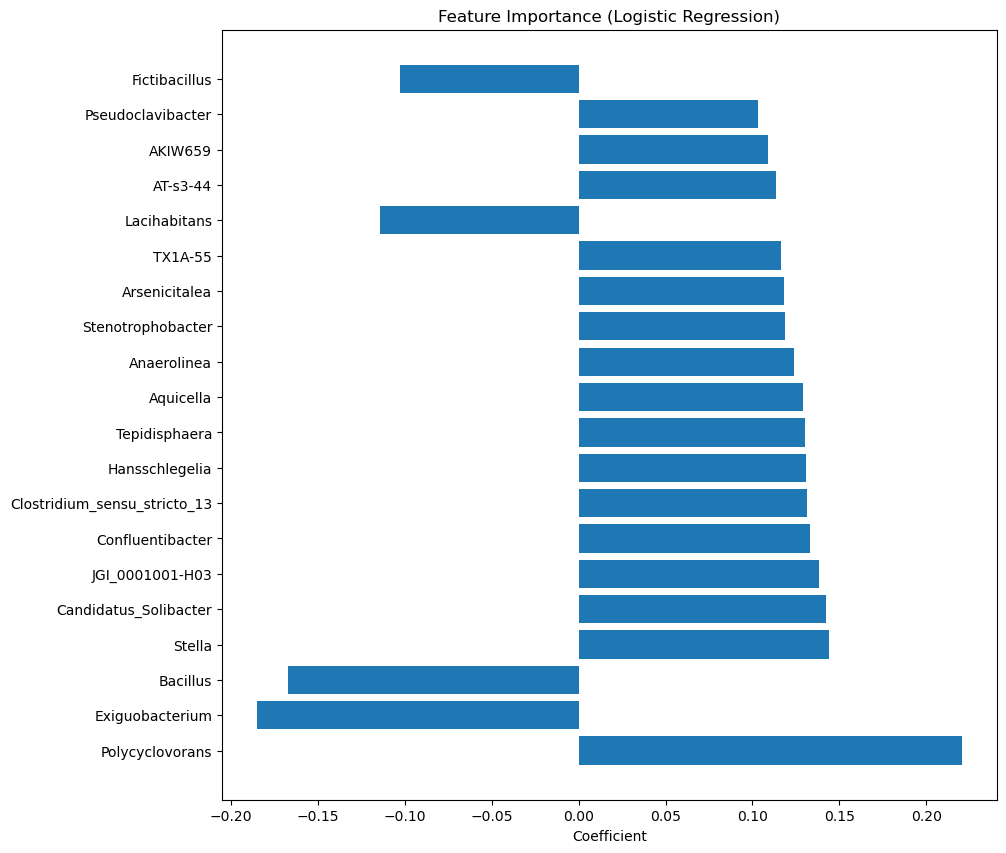

In [34]:
# plot the 20 most important features
plt.figure(figsize=(10, 10))
plt.barh(sorted_features[:20], sorted_coefficients[:20])
plt.xlabel("Coefficient")
plt.title("Feature Importance (Logistic Regression)")
plt.show()

In [35]:
# print the 20 most important features
print("Most important features: ")

for i in range(20):
    print(sorted_features[i], sorted_coefficients[i])

logreg_top20_feature_genus = sorted_features[:20]

Most important features: 
Polycyclovorans 0.22046714632085782
Exiguobacterium -0.18501644478679632
Bacillus -0.16731291920262098
Stella 0.14396358914739588
Candidatus_Solibacter 0.14223865710537245
JGI_0001001-H03 0.13832932718633054
Confluentibacter 0.1331516769955963
Clostridium_sensu_stricto_13 0.13112385381002784
Hansschlegelia 0.13087091080586974
Tepidisphaera 0.13048696440522398
Aquicella 0.12894682931353982
Anaerolinea 0.1240117545919301
Stenotrophobacter 0.1189125423120824
Arsenicitalea 0.11839719439692499
TX1A-55 0.11642564635881605
Lacihabitans -0.1145588182721946
AT-s3-44 0.11377897459217944
AKIW659 0.1086743497875021
Pseudoclavibacter 0.1033097508374719
Fictibacillus -0.10279121574793398


In [36]:
# find important features
importances = model_genus_RF.feature_importances_
sorted_idx = np.argsort(np.abs(importances))[::-1]
sorted_features = [feature_names[idx] for idx in sorted_idx]
sorted_importances = importances[sorted_idx]

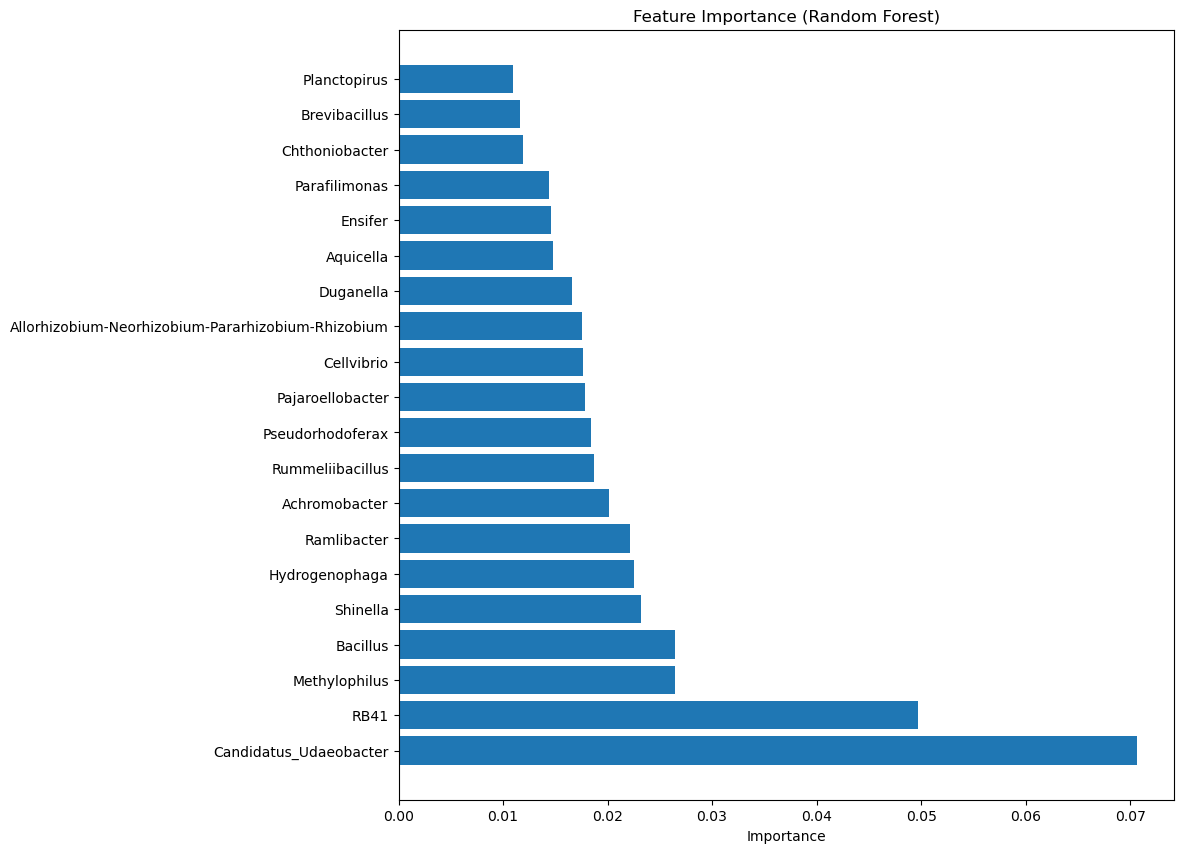

In [37]:
# plot the 20 most important features
plt.figure(figsize=(10, 10))
plt.barh(sorted_features[:20], sorted_importances[:20])
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()

In [38]:
# print the 20 most important features
print("Most important features predicted by Random Forest Classifier: ")

for i in range(20):
    print(sorted_features[i], sorted_importances[i])

RF_top20_feature_genus = sorted_features[:20]

Most important features predicted by Random Forest Classifier: 
Candidatus_Udaeobacter 0.07062682685763119
RB41 0.0497071179812262
Methylophilus 0.026463301108033566
Bacillus 0.02640419229684137
Shinella 0.023197296530762447
Hydrogenophaga 0.02253111690278967
Ramlibacter 0.02217408955832827
Achromobacter 0.02014364574327185
Rummeliibacillus 0.018723010619595453
Pseudorhodoferax 0.01843986331869936
Pajaroellobacter 0.017820093363647357
Cellvibrio 0.017635023068463405
Allorhizobium-Neorhizobium-Pararhizobium-Rhizobium 0.017511267593773493
Duganella 0.016590280752867205
Aquicella 0.014792367335457288
Ensifer 0.014588278843975818
Parafilimonas 0.01435112216814832
Chthoniobacter 0.0119376691059551
Brevibacillus 0.011580695491287174
Planctopirus 0.010972588483419697


In [39]:
# find important features
importances = model_genus_XGB.feature_importances_
sorted_idx = np.argsort(np.abs(importances))[::-1]
sorted_features = [feature_names[idx] for idx in sorted_idx]
sorted_importances = importances[sorted_idx]

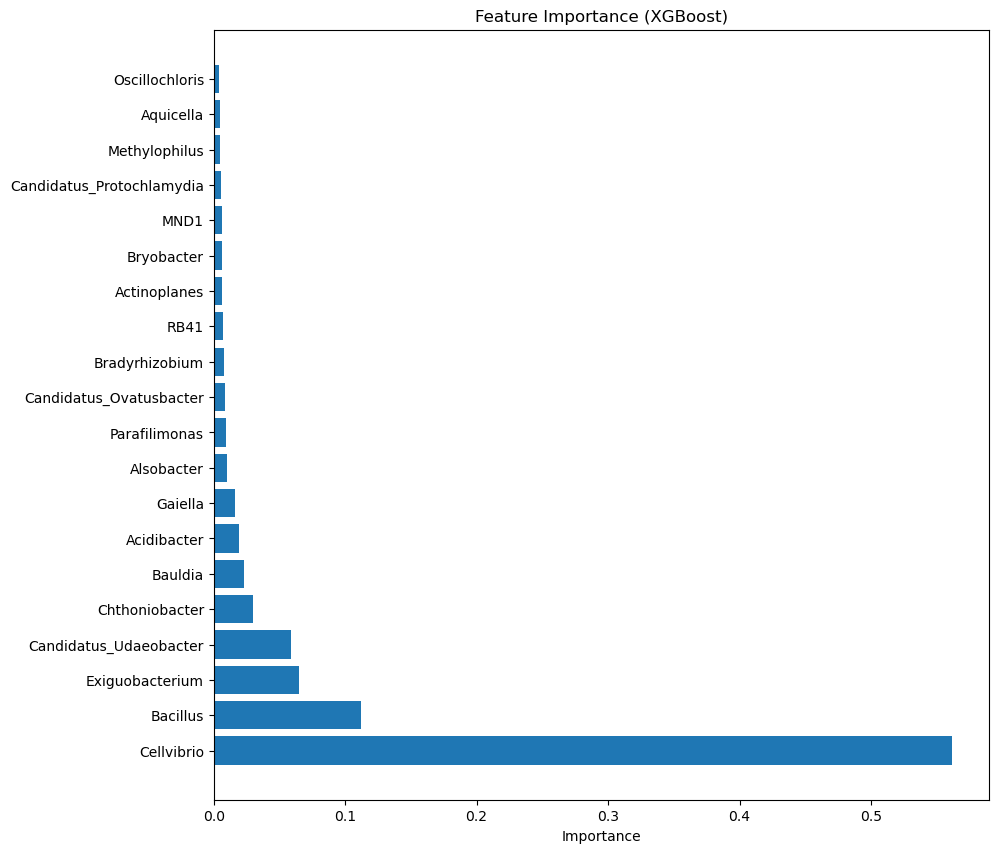

In [40]:
# plot the 20 most important features
plt.figure(figsize=(10, 10))
plt.barh(sorted_features[:20], sorted_importances[:20])
plt.xlabel("Importance")
plt.title("Feature Importance (XGBoost)")
plt.show()

In [41]:
# print the 20 most important features
print("Most important features predicted by XGBoost Classifier: ")

for i in range(20):
    print(sorted_features[i], sorted_importances[i])

XGB_top20_feature_genus = sorted_features[:20]

Most important features predicted by XGBoost Classifier: 
Cellvibrio 0.5614678
Bacillus 0.111815885
Exiguobacterium 0.0652117
Candidatus_Udaeobacter 0.058634598
Chthoniobacter 0.029554099
Bauldia 0.023357501
Acidibacter 0.019605272
Gaiella 0.015918527
Alsobacter 0.010386094
Parafilimonas 0.009595161
Candidatus_Ovatusbacter 0.008317264
Bradyrhizobium 0.0074469466
RB41 0.007193579
Actinoplanes 0.0066464497
Bryobacter 0.006433137
MND1 0.0059655868
Candidatus_Protochlamydia 0.0056066466
Methylophilus 0.005109738
Aquicella 0.0047788275
Oscillochloris 0.0039443616


In [42]:
# find common features
common_features = []
for feature in logreg_top20_feature_genus:
    if feature in RF_top20_feature_genus and feature in XGB_top20_feature_genus:
        common_features.append(feature)

print("Common features: ", common_features)

Common features:  ['Bacillus', 'Aquicella']


## Species Level

Now we group the data into species level. We see the model performance and the most important features.

In [43]:
# create species level data
df_species = df_abundance.groupby('Species').sum()
# remove columns that is not start with "Samp"
df_species = df_species[df_species.columns[df_species.columns.str.startswith('Samp')]]
df_species.head()

,Samp001,Samp002,Samp003,Samp004,Samp005,Samp006,Samp007,Samp008,Samp009,Samp010,...,Samp231,Samp232,Samp233,Samp234,Samp235,Samp236,Samp237,Samp238,Samp239,Samp240
Species,,,,,,,,,,,,,,,,,,,,,
abiegnus,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,1,0,0,0
acetylicum,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
acidiphila,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,1,0,0,0,0
adhaesivum,0,0,0,1,0,0,0,0,0,1,...,9,4,0,1,3,1,3,1,4,4
aerolata,0,0,0,1,0,0,1,0,1,0,...,33,24,4,5,13,14,7,23,21,13


In [44]:
# Get X and y
X = df_species.T.values
y = metadata["Fumigation"].values.astype(int)

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

# check how many data enries we have
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (192, 342)
Shape of X_test:  (48, 342)
Shape of y_train:  (192,)
Shape of y_test:  (48,)


In [45]:
# create model
model_spec_XGB = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# cv
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=40, random_state=42)
scores = cross_val_score(model_spec_XGB, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

# Print the mean and standard deviation of the scores
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.p

Cross-validated Accuracy: 0.98 (+/- 0.04)


In [46]:
# test model
model_spec_XGB.fit(X_train, y_train)
y_pred = model_spec_XGB.predict(X_test)

test_score_spec_XGB = model_spec_XGB.score(X_test, y_test)
cm_XGB_spec = confusion_matrix(y_test, y_pred)
# for roc curve
# only binary class, fumigated or not, convert from 3 classes to 2 classes
y_test_binary = np.where(y_test == 0, 0, 1)
y_pred_binary = np.where(y_pred == 0, 0, 1)
y_pred_proba = model_spec_XGB.predict_proba(X_test)
fpr_XGB_spec, tpr_XGB_spec, thresholds_XGB_spec = roc_curve(y_test_binary, y_pred_proba[:,1] + y_pred_proba[:,2])


print("Test Accuracy: %0.2f" % test_score_spec_XGB)

Test Accuracy: 1.00


In [47]:
# create model
model_spec_RF = RandomForestClassifier(random_state=42)

# cv
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=40, random_state=42)
scores = cross_val_score(model_spec_RF, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

# Print the mean and standard deviation of the scores
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross-validated Accuracy: 0.98 (+/- 0.04)


In [48]:
# test model
model_spec_RF.fit(X_train, y_train)
y_pred = model_spec_RF.predict(X_test)

test_score_spec_RF = model_spec_RF.score(X_test, y_test)
cm_RF_spec = confusion_matrix(y_test, y_pred)
# for roc curve
# only binary class, fumigated or not, convert from 3 classes to 2 classes
y_test_binary = np.where(y_test == 0, 0, 1)
y_pred_binary = np.where(y_pred == 0, 0, 1)
y_pred_proba = model_spec_RF.predict_proba(X_test)
fpr_RF_spec, tpr_RF_spec, thresholds_RF_spec = roc_curve(y_test_binary, y_pred_proba[:,1] + y_pred_proba[:,2])

print("Test Accuracy: %0.2f" % test_score_spec_RF)

Test Accuracy: 1.00


In [49]:
# normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# create model
model_spec_logreg = LogisticRegression(random_state=42)

# cv
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=40, random_state=42)

scores = cross_val_score(model_spec_logreg, X_train_scaled, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

# Print the mean and standard deviation of the scores
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross-validated Accuracy: 0.99 (+/- 0.03)


In [50]:
# test model
model_spec_logreg.fit(X_train_scaled, y_train)
y_pred = model_spec_logreg.predict(X_test_scaled)

test_score_spec_lr = model_spec_logreg.score(X_test_scaled, y_test)
cm_lr_spec = confusion_matrix(y_test, y_pred)
# for roc curve
# only binary class, fumigated or not, convert from 3 classes to 2 classes
y_test_binary = np.where(y_test == 0, 0, 1)
y_pred_binary = np.where(y_pred == 0, 0, 1)
y_pred_proba = model_spec_logreg.predict_proba(X_test_scaled)
fpr_lr_spec, tpr_lr_spec, thresholds_lr_spec = roc_curve(y_test_binary, y_pred_proba[:,1] + y_pred_proba[:,2])

print("Test Accuracy: %0.2f" % test_score_spec_lr)

Test Accuracy: 1.00


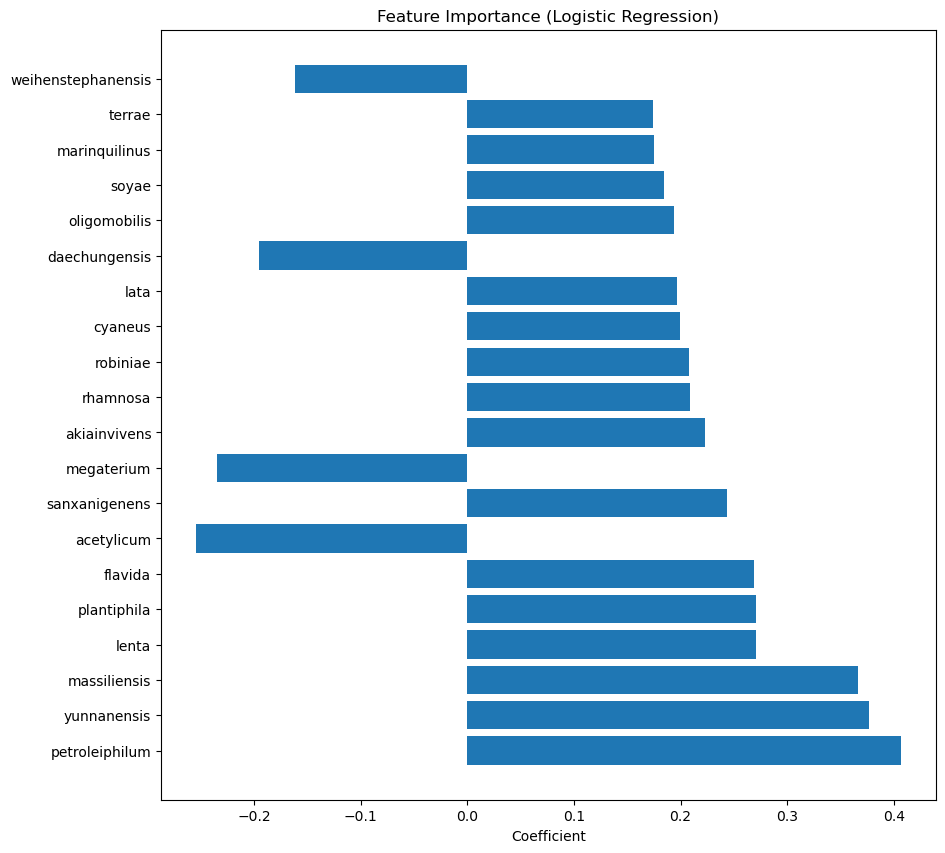

In [51]:
# find important features
coefficients = model_spec_logreg.coef_[0]
feature_names = list(df_species.T.columns)

# sort features by importance
sorted_idx = np.argsort(np.abs(coefficients))[::-1]
sorted_features = [feature_names[idx] for idx in sorted_idx]
sorted_coefficients = coefficients[sorted_idx]

# plot the 20 most important features
plt.figure(figsize=(10, 10))
plt.barh(sorted_features[:20], sorted_coefficients[:20])
plt.xlabel("Coefficient")
plt.title("Feature Importance (Logistic Regression)")
plt.show()

In [52]:
# print the 20 most important features
print("Most important features: ")

for i in range(20):
    print(sorted_features[i], sorted_coefficients[i])

logreg_top20_feature_spec = sorted_features[:20]

Most important features: 
petroleiphilum 0.4065052603444364
yunnanensis 0.376287581005231
massiliensis 0.36668199201512225
lenta 0.27113342356226144
plantiphila 0.27083297880231355
flavida 0.26916959046362526
acetylicum -0.25444427195698605
sanxanigenens 0.24372523977422375
megaterium -0.2349537165841297
akiainvivens 0.2227384279368648
rhamnosa 0.20897047777344385
robiniae 0.2081738297638607
cyaneus 0.19981852866214206
lata 0.19650369408087331
daechungensis -0.19550401935246448
oligomobilis 0.19360662363868364
soyae 0.18431458558838063
marinquilinus 0.17480158145270297
terrae 0.17390656263832502
weihenstephanensis -0.16220314953738818


In [53]:
# find important features
importances = model_spec_RF.feature_importances_
sorted_idx = np.argsort(np.abs(importances))[::-1]
sorted_features = [feature_names[idx] for idx in sorted_idx]
sorted_importances = importances[sorted_idx]

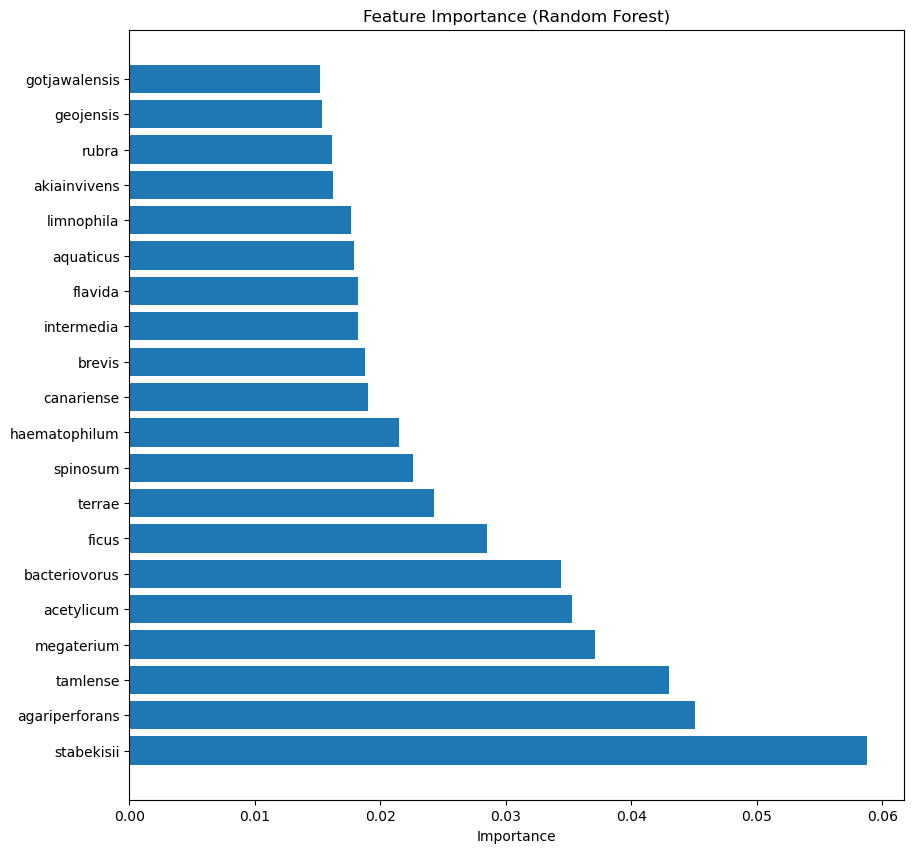

In [54]:
# plot the 20 most important features
plt.figure(figsize=(10, 10))
plt.barh(sorted_features[:20], sorted_importances[:20])
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()

In [55]:
# print the 20 most important features
print("Most important features predicted by Random Forest Classifier: ")

for i in range(20):
    print(sorted_features[i], sorted_importances[i])

RF_top20_feature_spec = sorted_features[:20]

Most important features predicted by Random Forest Classifier: 
stabekisii 0.05882592101458158
agariperforans 0.04506328383329089
tamlense 0.042987096346448546
megaterium 0.03713558691869802
acetylicum 0.03525283200100351
bacteriovorus 0.034425054305932096
ficus 0.02849008261018333
terrae 0.024283146104191834
spinosum 0.022602539952201597
haematophilum 0.02149623771956869
canariense 0.0190139365356412
brevis 0.01876589222717848
intermedia 0.018247350375918948
flavida 0.01822085125749341
aquaticus 0.01787041932600749
limnophila 0.017661370231017614
akiainvivens 0.016206923564229085
rubra 0.016187684344018096
geojensis 0.015347018026690064
gotjawalensis 0.015180934692334613


In [56]:
# find important features
importances = model_spec_XGB.feature_importances_
sorted_idx = np.argsort(np.abs(importances))[::-1]
sorted_features = [feature_names[idx] for idx in sorted_idx]
sorted_importances = importances[sorted_idx]

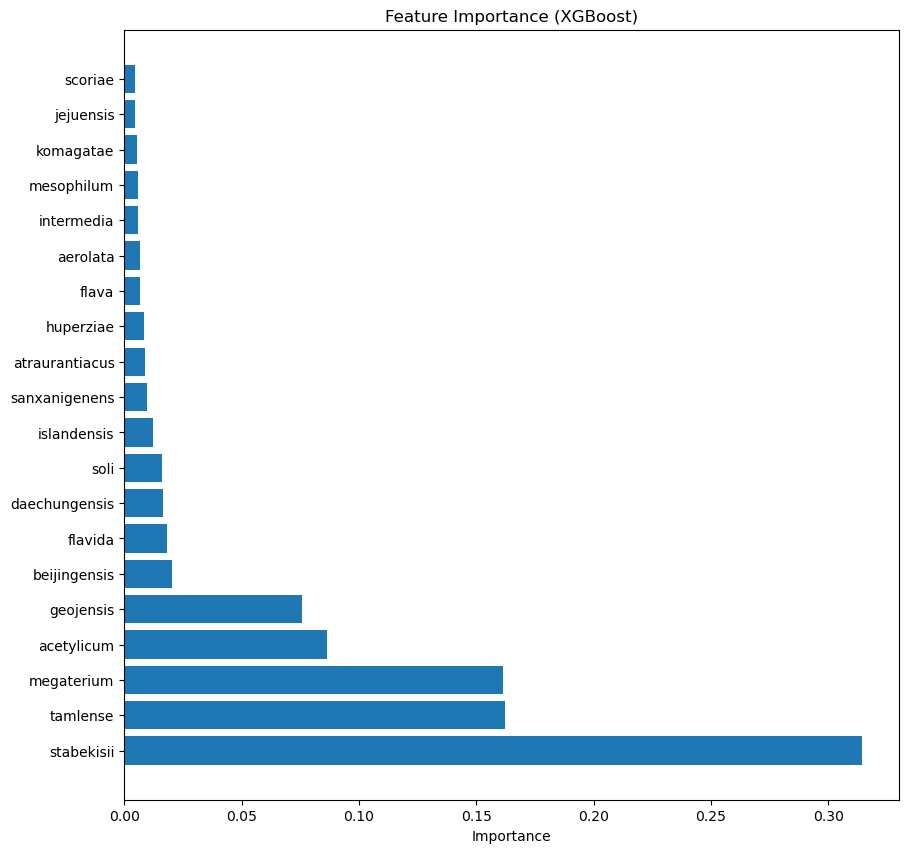

In [57]:
# plot the 20 most important features
plt.figure(figsize=(10, 10))
plt.barh(sorted_features[:20], sorted_importances[:20])
plt.xlabel("Importance")
plt.title("Feature Importance (XGBoost)")
plt.show()

In [58]:
# print the 20 most important features
print("Most important features predicted by XGBoost Classifier: ")

for i in range(20):
    print(sorted_features[i], sorted_importances[i])

XGB_top20_feature_spec = sorted_features[:20]

Most important features predicted by XGBoost Classifier: 
stabekisii 0.31451154
tamlense 0.1622369
megaterium 0.16120921
acetylicum 0.086287476
geojensis 0.07564779
beijingensis 0.020376747
flavida 0.01817712
daechungensis 0.016706984
soli 0.01611398
islandensis 0.012237041
sanxanigenens 0.0098202545
atraurantiacus 0.009002697
huperziae 0.008473369
flava 0.0067626666
aerolata 0.006574658
intermedia 0.0060106814
mesophilum 0.0058633178
komagatae 0.005353705
jejuensis 0.004501699
scoriae 0.0044305576


In [59]:
# find common features
common_features = []
for feature in logreg_top20_feature_spec:
    if feature in RF_top20_feature_spec and feature in XGB_top20_feature_spec:
        common_features.append(feature)

print("Common features: ", common_features)

Common features:  ['flavida', 'acetylicum', 'megaterium']


## Phylum Level

In [60]:
# Phylum level data
df_phylum = df_abundance.groupby('Phylum').sum()
# remove columns that is not start with "Samp"
df_phylum = df_phylum[df_phylum.columns[df_phylum.columns.str.startswith('Samp')]]
df_phylum.head()

,Samp001,Samp002,Samp003,Samp004,Samp005,Samp006,Samp007,Samp008,Samp009,Samp010,...,Samp231,Samp232,Samp233,Samp234,Samp235,Samp236,Samp237,Samp238,Samp239,Samp240
Phylum,,,,,,,,,,,,,,,,,,,,,
Acidobacteria,734,63,570,498,327,211,1188,647,643,1354,...,898,519,2225,1128,1539,2033,2677,2810,2264,1758
Actinobacteria,392,32,322,480,120,107,446,332,326,460,...,4797,2350,2582,1548,3249,4785,3051,3052,2969,2875
Armatimonadetes,31,0,20,9,5,7,43,27,34,48,...,56,27,63,27,36,74,55,37,65,59
BRC1,19,0,9,5,7,5,27,19,16,26,...,33,15,21,20,15,16,27,22,42,24
Bacteroidetes,1422,122,991,933,271,457,1240,1322,1075,1853,...,4356,2486,1453,755,1214,2011,1615,1731,1618,1495


In [61]:
# Get X and y
X = df_phylum.T.values
y = metadata["Fumigation"].values.astype(int)

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

# check how many data enries we have
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (192, 43)
Shape of X_test:  (48, 43)
Shape of y_train:  (192,)
Shape of y_test:  (48,)


In [62]:
# create model
model_phylum_XGB = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# cv
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=40, random_state=42)
scores = cross_val_score(model_phylum_XGB, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

# Print the mean and standard deviation of the scores
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.p

Cross-validated Accuracy: 0.98 (+/- 0.04)


In [63]:
# test model
model_phylum_XGB.fit(X_train, y_train)
y_pred = model_phylum_XGB.predict(X_test)

test_score_phylum_XGB = model_phylum_XGB.score(X_test, y_test)
cm_XGB_phylum = confusion_matrix(y_test, y_pred)
# for roc curve
# only binary class, fumigated or not, convert from 3 classes to 2 classes
y_test_binary = np.where(y_test == 0, 0, 1)
y_pred_binary = np.where(y_pred == 0, 0, 1)
y_pred_proba = model_phylum_XGB.predict_proba(X_test)
fpr_XGB_phylum, tpr_XGB_phylum, thresholds_XGB_phylum = roc_curve(y_test_binary, y_pred_proba[:,1] + y_pred_proba[:,2])

print("Test Accuracy: %0.2f" % test_score_phylum_XGB)

Test Accuracy: 0.98


In [64]:
# create model
model_phylum_RF = RandomForestClassifier(random_state=42)

# cv
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=40, random_state=42)
scores = cross_val_score(model_phylum_RF, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

# Print the mean and standard deviation of the scores
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross-validated Accuracy: 1.00 (+/- 0.02)


In [65]:
# test model
model_phylum_RF.fit(X_train, y_train)
y_pred = model_phylum_RF.predict(X_test)

test_score_phylum_RF = model_phylum_RF.score(X_test, y_test)
cm_RF_phylum = confusion_matrix(y_test, y_pred)
# for roc curve
# only binary class, fumigated or not, convert from 3 classes to 2 classes
y_test_binary = np.where(y_test == 0, 0, 1)
y_pred_binary = np.where(y_pred == 0, 0, 1)
y_pred_proba = model_phylum_RF.predict_proba(X_test)
fpr_RF_phylum, tpr_RF_phylum, thresholds_RF_phylum = roc_curve(y_test_binary, y_pred_proba[:,1] + y_pred_proba[:,2])

print("Test Accuracy: %0.2f" % test_score_phylum_RF)

Test Accuracy: 0.96


In [66]:
# normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# create model
model_phylum_logreg = LogisticRegression(random_state=42)

# cv
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=40, random_state=42)

scores = cross_val_score(model_phylum_logreg, X_train_scaled, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

# Print the mean and standard deviation of the scores
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross-validated Accuracy: 1.00 (+/- 0.02)


In [67]:
# test model
model_phylum_logreg.fit(X_train_scaled, y_train)
y_pred = model_phylum_logreg.predict(X_test_scaled)

test_score_phylum_lr = model_phylum_logreg.score(X_test_scaled, y_test)
cm_lr_phylum = confusion_matrix(y_test, y_pred)
# for roc curve
# only binary class, fumigated or not, convert from 3 classes to 2 classes
y_test_binary = np.where(y_test == 0, 0, 1)
y_pred_binary = np.where(y_pred == 0, 0, 1)
y_pred_proba = model_phylum_logreg.predict_proba(X_test_scaled)
fpr_lr_phylum, tpr_lr_phylum, thresholds_lr_phylum = roc_curve(y_test_binary, y_pred_proba[:,1] + y_pred_proba[:,2])

print("Test Accuracy: %0.2f" % test_score_phylum_lr)

Test Accuracy: 0.98


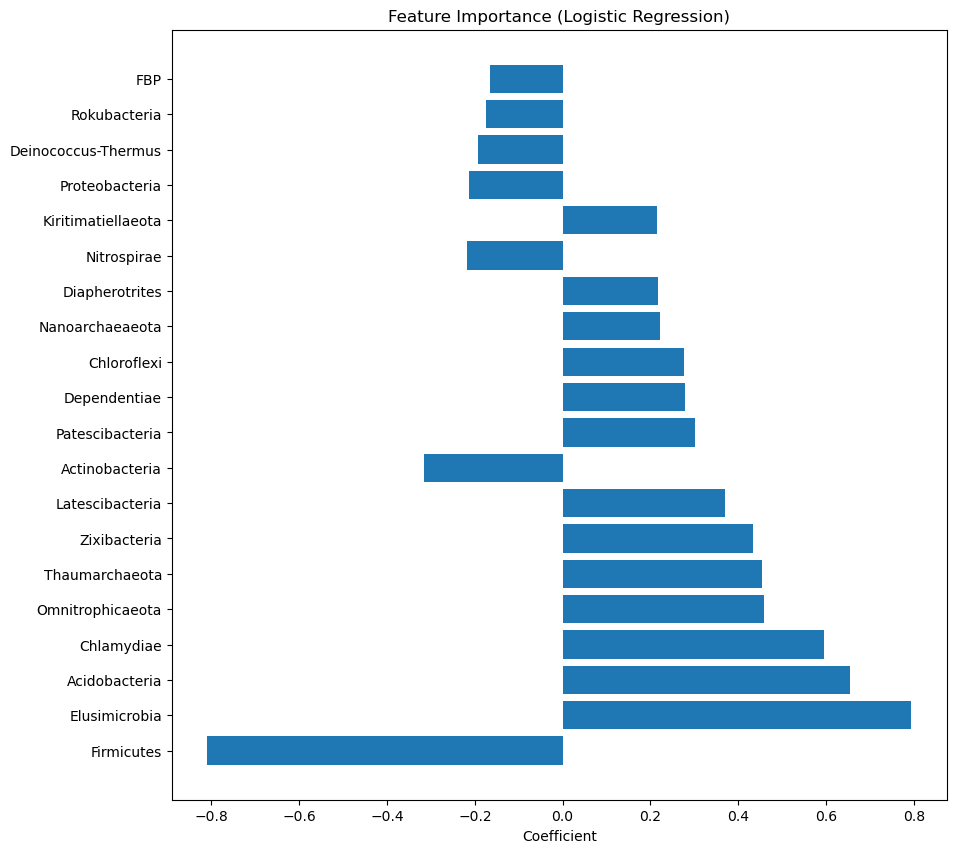

In [68]:
# find important features
coefficients = model_phylum_logreg.coef_[0]
feature_names = list(df_phylum.T.columns)

# sort features by importance  
sorted_idx = np.argsort(np.abs(coefficients))[::-1]
sorted_features = [feature_names[idx] for idx in sorted_idx]
sorted_coefficients = coefficients[sorted_idx]

# plot the 20 most important features
plt.figure(figsize=(10, 10))
plt.barh(sorted_features[:20], sorted_coefficients[:20])
plt.xlabel("Coefficient")
plt.title("Feature Importance (Logistic Regression)")
plt.show()

In [69]:
# print the 20 most important features
print("Most important features: ")

for i in range(20):
    print(sorted_features[i], sorted_coefficients[i])

logreg_top20_feature_phylum = sorted_features[:20]

Most important features: 
Firmicutes -0.8102972732630099
Elusimicrobia 0.794541254160502
Acidobacteria 0.6539515992296793
Chlamydiae 0.5962312793111979
Omnitrophicaeota 0.45917584327034805
Thaumarchaeota 0.45430069075298385
Zixibacteria 0.43338466551671645
Latescibacteria 0.3699538567561247
Actinobacteria -0.3157541180304931
Patescibacteria 0.3007511799866925
Dependentiae 0.2789146064043045
Chloroflexi 0.27535787161098596
Nanoarchaeaeota 0.22220183634363483
Diapherotrites 0.21812675343354887
Nitrospirae -0.21759193708891533
Kiritimatiellaeota 0.21539279036218592
Proteobacteria -0.2144313089918795
Deinococcus-Thermus -0.1920482570852306
Rokubacteria -0.17454676043513537
FBP -0.16654319529954356


In [70]:
# find important features
importances = model_phylum_RF.feature_importances_
sorted_idx = np.argsort(np.abs(importances))[::-1]
sorted_features = [feature_names[idx] for idx in sorted_idx]
sorted_importances = importances[sorted_idx]

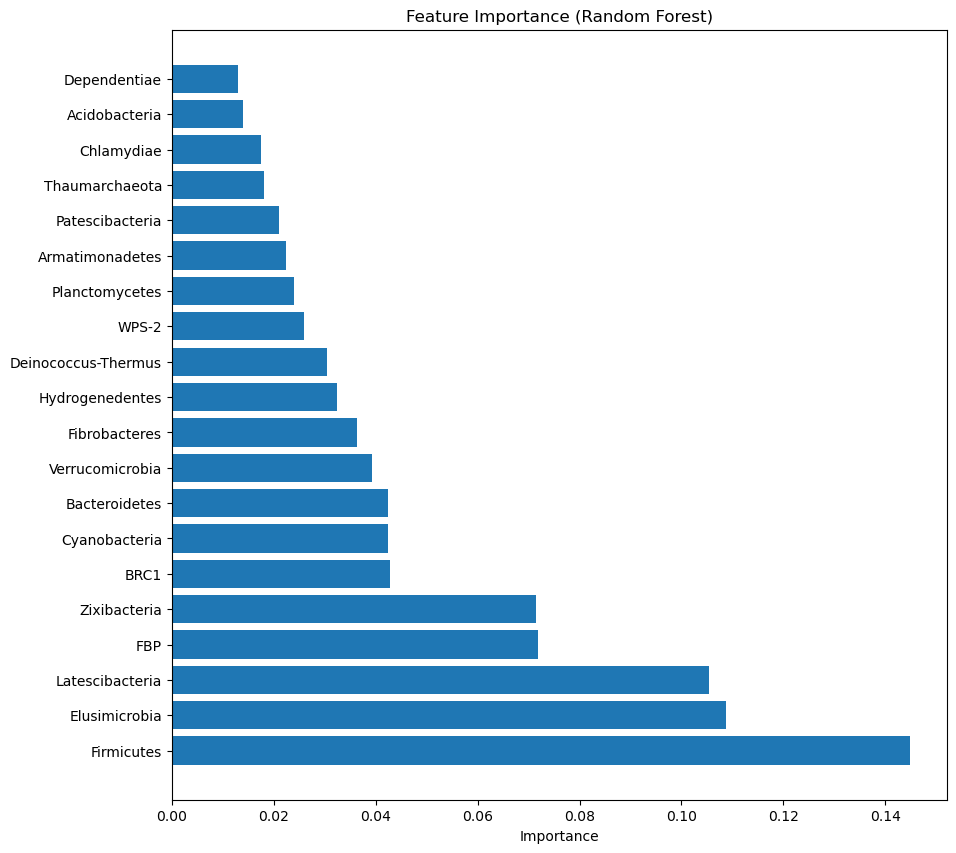

In [71]:
# plot the 20 most important features
plt.figure(figsize=(10, 10))
plt.barh(sorted_features[:20], sorted_importances[:20])
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()

In [72]:
# print the 20 most important features
print("Most important features predicted by Random Forest Classifier: ")

for i in range(20):
    print(sorted_features[i], sorted_importances[i])

RF_top20_feature_phylum = sorted_features[:20]

Most important features predicted by Random Forest Classifier: 
Firmicutes 0.14479875013889262
Elusimicrobia 0.10880247716709676
Latescibacteria 0.10540002273803953
FBP 0.07181823243179175
Zixibacteria 0.07146875344453785
BRC1 0.042804056135179715
Cyanobacteria 0.042479695485615414
Bacteroidetes 0.0423317330096118
Verrucomicrobia 0.03935924032923351
Fibrobacteres 0.036284453252086846
Hydrogenedentes 0.032459728221402744
Deinococcus-Thermus 0.030486866820187055
WPS-2 0.025901328653353484
Planctomycetes 0.024068540772252327
Armatimonadetes 0.022460745048859802
Patescibacteria 0.021053708450393546
Thaumarchaeota 0.01815252485891909
Chlamydiae 0.017436813298273415
Acidobacteria 0.014046851457354993
Dependentiae 0.013011098416049117


In [73]:
# find important features
importances = model_phylum_XGB.feature_importances_
sorted_idx = np.argsort(np.abs(importances))[::-1]
sorted_features = [feature_names[idx] for idx in sorted_idx]
sorted_importances = importances[sorted_idx]

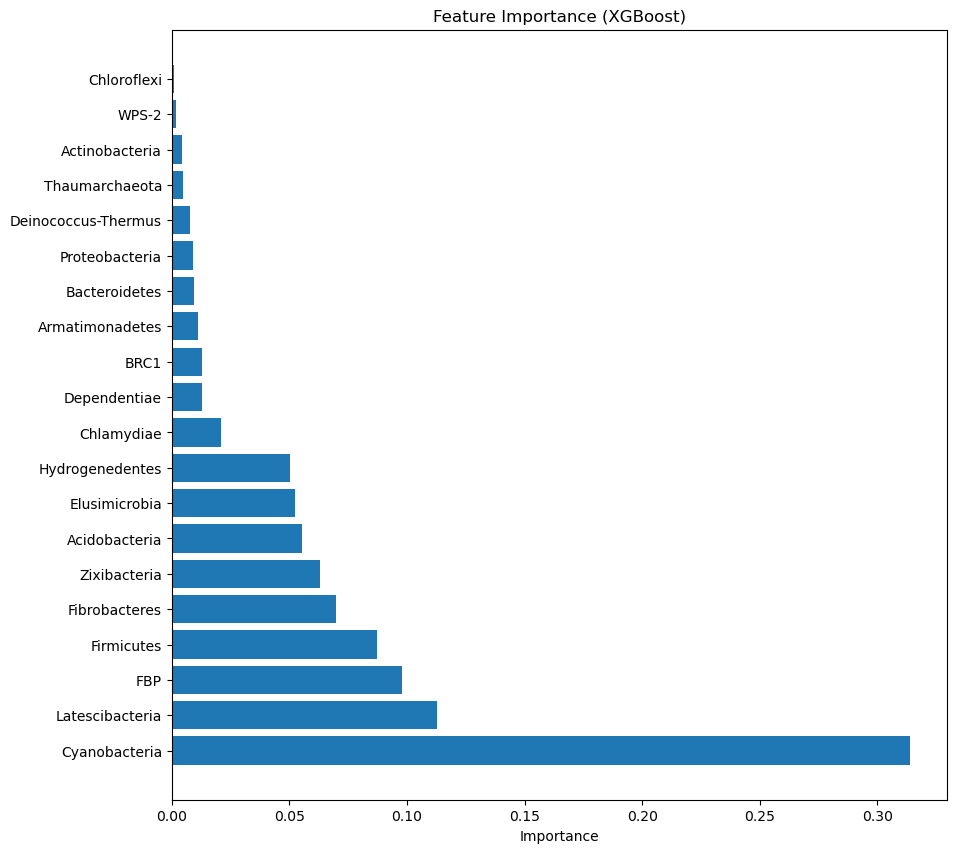

In [74]:
# plot the 20 most important features
plt.figure(figsize=(10, 10))
plt.barh(sorted_features[:20], sorted_importances[:20])
plt.xlabel("Importance")
plt.title("Feature Importance (XGBoost)")
plt.show()

In [75]:
# print the 20 most important features
print("Most important features predicted by XGBoost Classifier: ")

for i in range(20):
    print(sorted_features[i], sorted_importances[i])

XGB_top20_feature_phylum = sorted_features[:20]

Most important features predicted by XGBoost Classifier: 
Cyanobacteria 0.313743
Latescibacteria 0.112695284
FBP 0.098086804
Firmicutes 0.08717501
Fibrobacteres 0.069662586
Zixibacteria 0.06281914
Acidobacteria 0.05554615
Elusimicrobia 0.05254026
Hydrogenedentes 0.050453745
Chlamydiae 0.02080682
Dependentiae 0.012837684
BRC1 0.012826335
Armatimonadetes 0.011223972
Bacteroidetes 0.009531383
Proteobacteria 0.008864335
Deinococcus-Thermus 0.007894886
Thaumarchaeota 0.004861912
Actinobacteria 0.004385304
WPS-2 0.0017699436
Chloroflexi 0.00079618255


In [76]:
# find common features
common_features = []

for feature in logreg_top20_feature_phylum:
    if feature in RF_top20_feature_phylum and feature in XGB_top20_feature_phylum:
        common_features.append(feature)

print("Common features: ", common_features)

Common features:  ['Firmicutes', 'Elusimicrobia', 'Acidobacteria', 'Chlamydiae', 'Thaumarchaeota', 'Zixibacteria', 'Latescibacteria', 'Dependentiae', 'Deinococcus-Thermus', 'FBP']


## More Plots

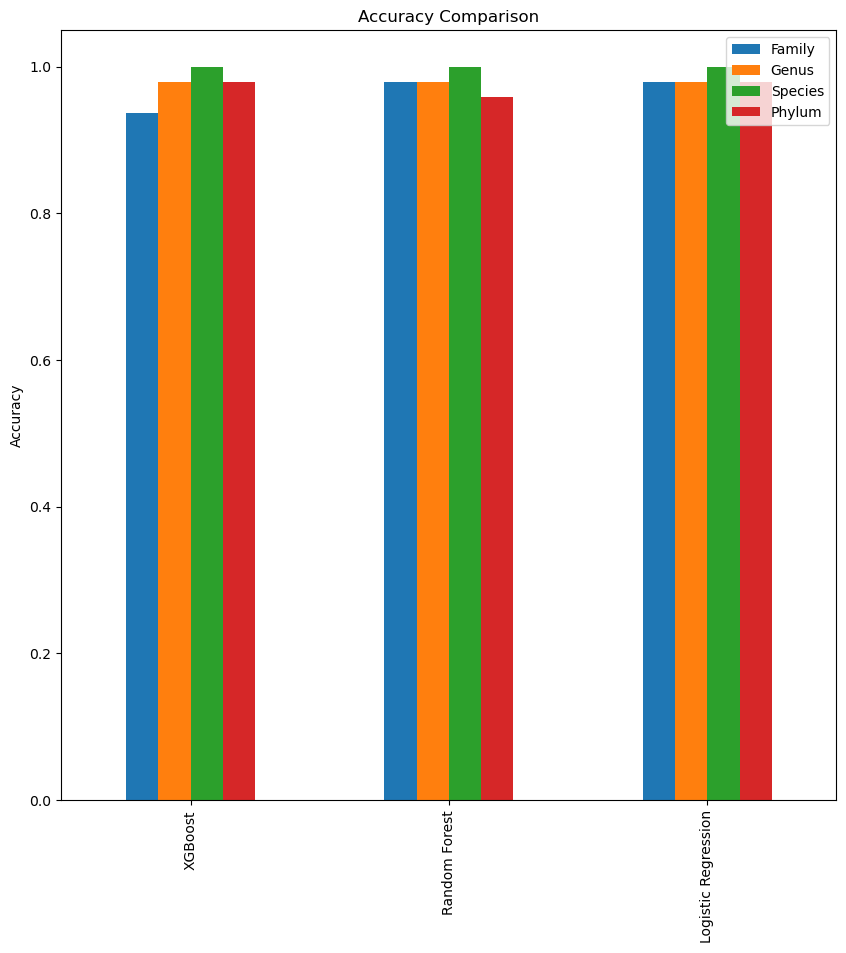

In [77]:
# Accuracy Comparison Plot

# create data

data = {'Family': [test_score_fam_XGB, test_score_fam_RF, test_score_fam_lr],
        'Genus': [test_score_genus_XGB, test_score_genus_RF, test_score_genus_lr],
        'Species': [test_score_spec_XGB, test_score_spec_RF, test_score_spec_lr],
        'Phylum': [test_score_phylum_XGB, test_score_phylum_RF, test_score_phylum_lr]}

df = pd.DataFrame(data)

# plot
df.plot(kind='bar', figsize=(10, 10))
plt.xticks(np.arange(3), ('XGBoost', 'Random Forest', 'Logistic Regression'))
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.show()

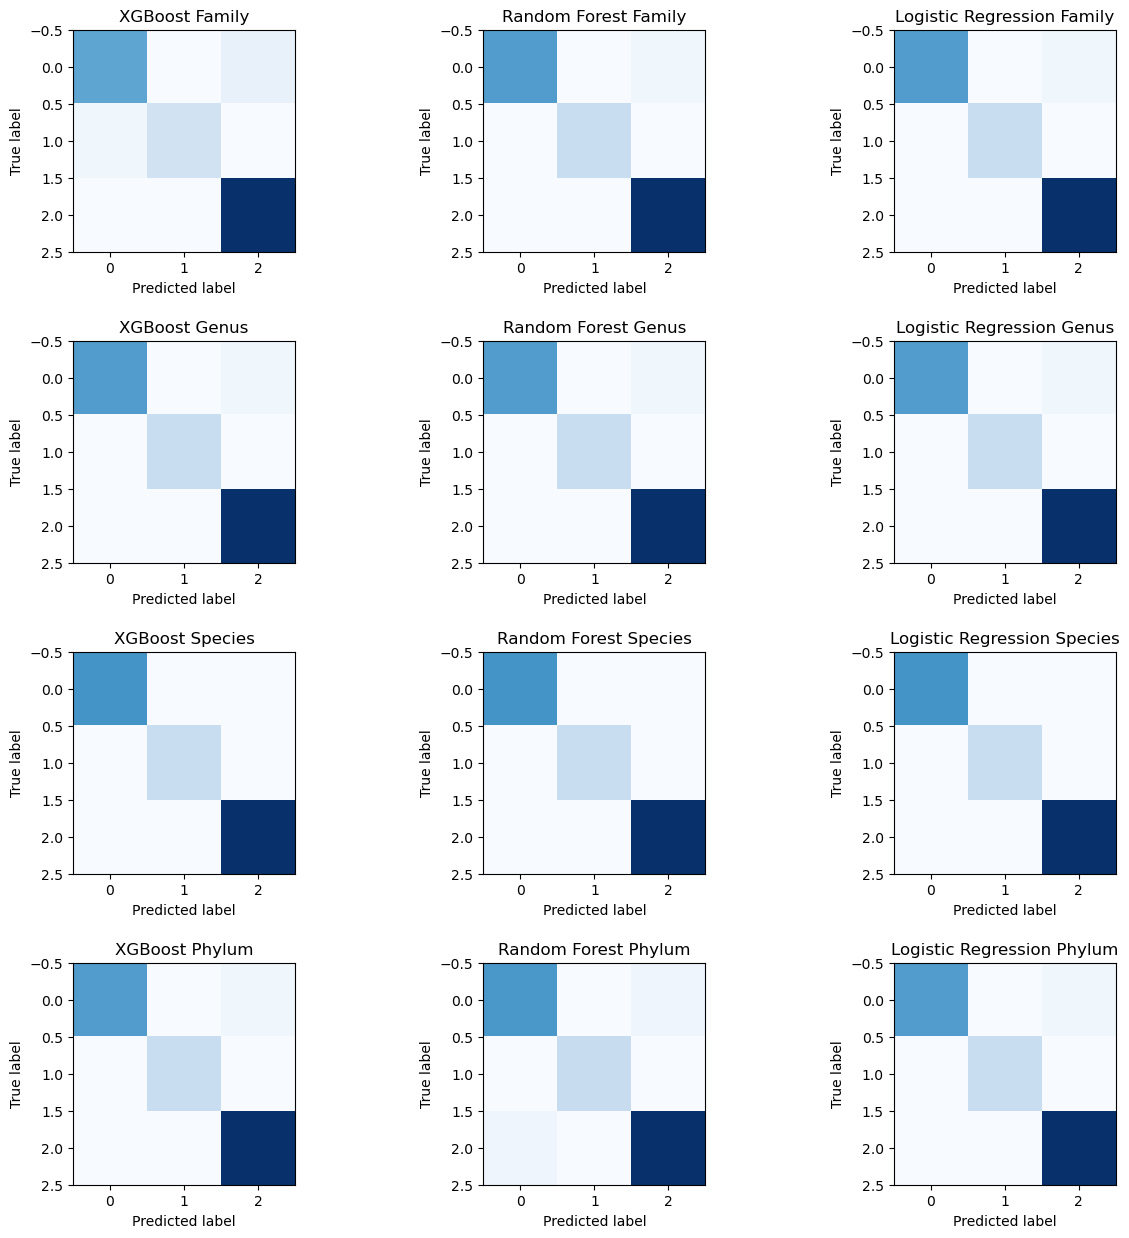

In [78]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

# plot confusion matrix

fig, ax = plt.subplots(4, 3, figsize=(15, 15))

# family
ax[0, 0].imshow(cm_XGB_fam , cmap=plt.cm.Blues)
ax[0, 0].set_title('XGBoost Family')
ax[0, 0].set_ylabel('True label')
ax[0, 0].set_xlabel('Predicted label')

ax[0, 1].imshow(cm_RF_fam, cmap=plt.cm.Blues)
ax[0, 1].set_title('Random Forest Family')
ax[0, 1].set_ylabel('True label')
ax[0, 1].set_xlabel('Predicted label')

ax[0, 2].imshow(cm_lr_fam, cmap=plt.cm.Blues)
ax[0, 2].set_title('Logistic Regression Family')
ax[0, 2].set_ylabel('True label')
ax[0, 2].set_xlabel('Predicted label')

# genus
ax[1, 0].imshow(cm_XGB_genus, cmap=plt.cm.Blues)
ax[1, 0].set_title('XGBoost Genus')
ax[1, 0].set_ylabel('True label')
ax[1, 0].set_xlabel('Predicted label')

ax[1, 1].imshow(cm_RF_genus, cmap=plt.cm.Blues)
ax[1, 1].set_title('Random Forest Genus')   
ax[1, 1].set_ylabel('True label')
ax[1, 1].set_xlabel('Predicted label')

ax[1, 2].imshow(cm_lr_genus, cmap=plt.cm.Blues)
ax[1, 2].set_title('Logistic Regression Genus')
ax[1, 2].set_ylabel('True label')
ax[1, 2].set_xlabel('Predicted label')

# species
ax[2, 0].imshow(cm_XGB_spec, cmap=plt.cm.Blues)
ax[2, 0].set_title('XGBoost Species')
ax[2, 0].set_ylabel('True label')
ax[2, 0].set_xlabel('Predicted label')

ax[2, 1].imshow(cm_RF_spec, cmap=plt.cm.Blues)
ax[2, 1].set_title('Random Forest Species')
ax[2, 1].set_ylabel('True label')
ax[2, 1].set_xlabel('Predicted label')

ax[2, 2].imshow(cm_lr_spec, cmap=plt.cm.Blues)
ax[2, 2].set_title('Logistic Regression Species')
ax[2, 2].set_ylabel('True label')
ax[2, 2].set_xlabel('Predicted label')

# phylum
ax[3, 0].imshow(cm_XGB_phylum, cmap=plt.cm.Blues)
ax[3, 0].set_title('XGBoost Phylum')
ax[3, 0].set_ylabel('True label')
ax[3, 0].set_xlabel('Predicted label')

ax[3, 1].imshow(cm_RF_phylum, cmap=plt.cm.Blues)
ax[3, 1].set_title('Random Forest Phylum')
ax[3, 1].set_ylabel('True label')
ax[3, 1].set_xlabel('Predicted label')

ax[3, 2].imshow(cm_lr_phylum, cmap=plt.cm.Blues)
ax[3, 2].set_title('Logistic Regression Phylum')
ax[3, 2].set_ylabel('True label')
ax[3, 2].set_xlabel('Predicted label')

plt.subplots_adjust(hspace=0.4)  

plt.show()

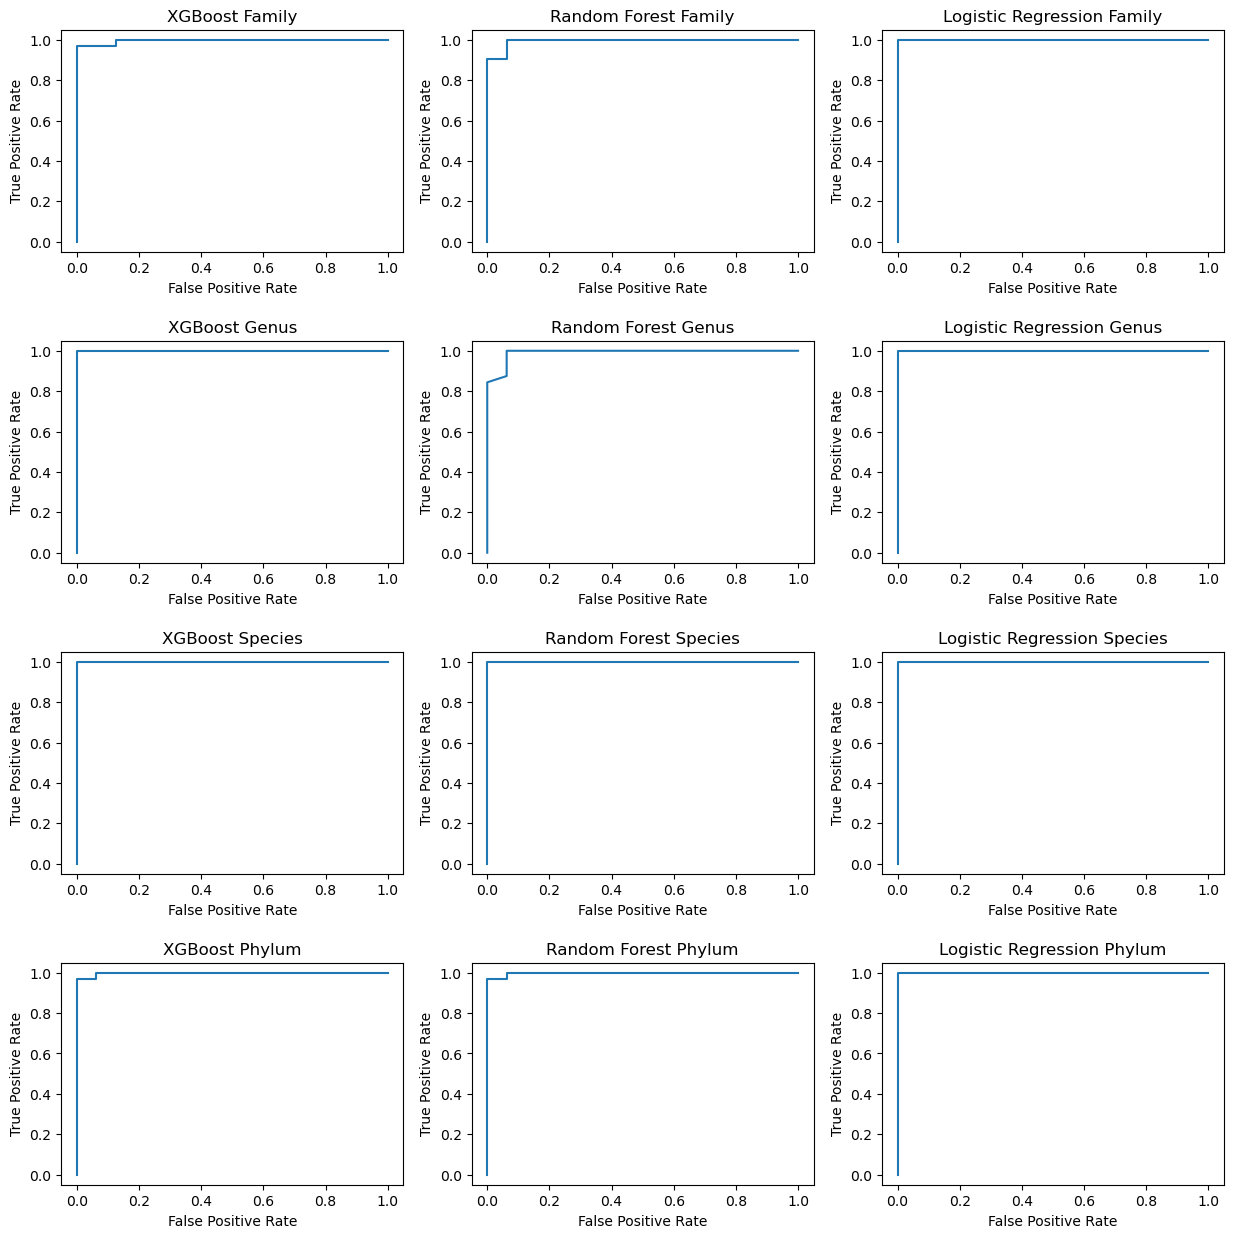

In [79]:
# ROC Curve

# plot roc curve

fig, ax = plt.subplots(4, 3, figsize=(15, 15))

# family
ax[0, 0].plot(fpr_XGB_fam, tpr_XGB_fam)
ax[0, 0].set_title('XGBoost Family')
ax[0, 0].set_ylabel('True Positive Rate')
ax[0, 0].set_xlabel('False Positive Rate')

ax[0, 1].plot(fpr_RF_fam, tpr_RF_fam)
ax[0, 1].set_title('Random Forest Family')
ax[0, 1].set_ylabel('True Positive Rate')
ax[0, 1].set_xlabel('False Positive Rate')

ax[0, 2].plot(fpr_lr_fam, tpr_lr_fam)
ax[0, 2].set_title('Logistic Regression Family')
ax[0, 2].set_ylabel('True Positive Rate')
ax[0, 2].set_xlabel('False Positive Rate')

# genus
ax[1, 0].plot(fpr_XGB_genus, tpr_XGB_genus)
ax[1, 0].set_title('XGBoost Genus')
ax[1, 0].set_ylabel('True Positive Rate')
ax[1, 0].set_xlabel('False Positive Rate')

ax[1, 1].plot(fpr_RF_genus, tpr_RF_genus)
ax[1, 1].set_title('Random Forest Genus')
ax[1, 1].set_ylabel('True Positive Rate')
ax[1, 1].set_xlabel('False Positive Rate')

ax[1, 2].plot(fpr_lr_genus, tpr_lr_genus)
ax[1, 2].set_title('Logistic Regression Genus')
ax[1, 2].set_ylabel('True Positive Rate')
ax[1, 2].set_xlabel('False Positive Rate')

# species
ax[2, 0].plot(fpr_XGB_spec, tpr_XGB_spec)
ax[2, 0].set_title('XGBoost Species')
ax[2, 0].set_ylabel('True Positive Rate')
ax[2, 0].set_xlabel('False Positive Rate')

ax[2, 1].plot(fpr_RF_spec, tpr_RF_spec)
ax[2, 1].set_title('Random Forest Species')
ax[2, 1].set_ylabel('True Positive Rate')
ax[2, 1].set_xlabel('False Positive Rate')

ax[2, 2].plot(fpr_lr_spec, tpr_lr_spec)
ax[2, 2].set_title('Logistic Regression Species')
ax[2, 2].set_ylabel('True Positive Rate')
ax[2, 2].set_xlabel('False Positive Rate')

# phylum
ax[3, 0].plot(fpr_XGB_phylum, tpr_XGB_phylum)
ax[3, 0].set_title('XGBoost Phylum')
ax[3, 0].set_ylabel('True Positive Rate')
ax[3, 0].set_xlabel('False Positive Rate')

ax[3, 1].plot(fpr_RF_phylum, tpr_RF_phylum)
ax[3, 1].set_title('Random Forest Phylum')
ax[3, 1].set_ylabel('True Positive Rate')
ax[3, 1].set_xlabel('False Positive Rate')

ax[3, 2].plot(fpr_lr_phylum, tpr_lr_phylum)
ax[3, 2].set_title('Logistic Regression Phylum')
ax[3, 2].set_ylabel('True Positive Rate')
ax[3, 2].set_xlabel('False Positive Rate')

plt.subplots_adjust(hspace=0.4)  

plt.show()

In [80]:
# display AUC

auc_XGB_fam = auc(fpr_XGB_fam, tpr_XGB_fam)
auc_RF_fam = auc(fpr_RF_fam, tpr_RF_fam)
auc_lr_fam = auc(fpr_lr_fam, tpr_lr_fam)

auc_XGB_genus = auc(fpr_XGB_genus, tpr_XGB_genus)
auc_RF_genus = auc(fpr_RF_genus, tpr_RF_genus)
auc_lr_genus = auc(fpr_lr_genus, tpr_lr_genus)

auc_XGB_spec = auc(fpr_XGB_spec, tpr_XGB_spec)
auc_RF_spec = auc(fpr_RF_spec, tpr_RF_spec)
auc_lr_spec = auc(fpr_lr_spec, tpr_lr_spec)

auc_XGB_phylum = auc(fpr_XGB_phylum, tpr_XGB_phylum)
auc_RF_phylum = auc(fpr_RF_phylum, tpr_RF_phylum)
auc_lr_phylum = auc(fpr_lr_phylum, tpr_lr_phylum)

print("AUC for XGBoost Family: ", auc_XGB_fam)
print("AUC for Random Forest Family: ", auc_RF_fam)
print("AUC for Logistic Regression Family: ", auc_lr_fam)

print("AUC for XGBoost Genus: ", auc_XGB_genus)
print("AUC for Random Forest Genus: ", auc_RF_genus)
print("AUC for Logistic Regression Genus: ", auc_lr_genus)

print("AUC for XGBoost Species: ", auc_XGB_spec)
print("AUC for Random Forest Species: ", auc_RF_spec)
print("AUC for Logistic Regression Species: ", auc_lr_spec)

print("AUC for XGBoost Phylum: ", auc_XGB_phylum)
print("AUC for Random Forest Phylum: ", auc_RF_phylum)
print("AUC for Logistic Regression Phylum: ", auc_lr_phylum)

AUC for XGBoost Family:  0.99609375
AUC for Random Forest Family:  0.994140625
AUC for Logistic Regression Family:  1.0
AUC for XGBoost Genus:  1.0
AUC for Random Forest Genus:  0.9912109375
AUC for Logistic Regression Genus:  1.0
AUC for XGBoost Species:  1.0
AUC for Random Forest Species:  1.0
AUC for Logistic Regression Species:  1.0
AUC for XGBoost Phylum:  0.998046875
AUC for Random Forest Phylum:  0.998046875
AUC for Logistic Regression Phylum:  1.0


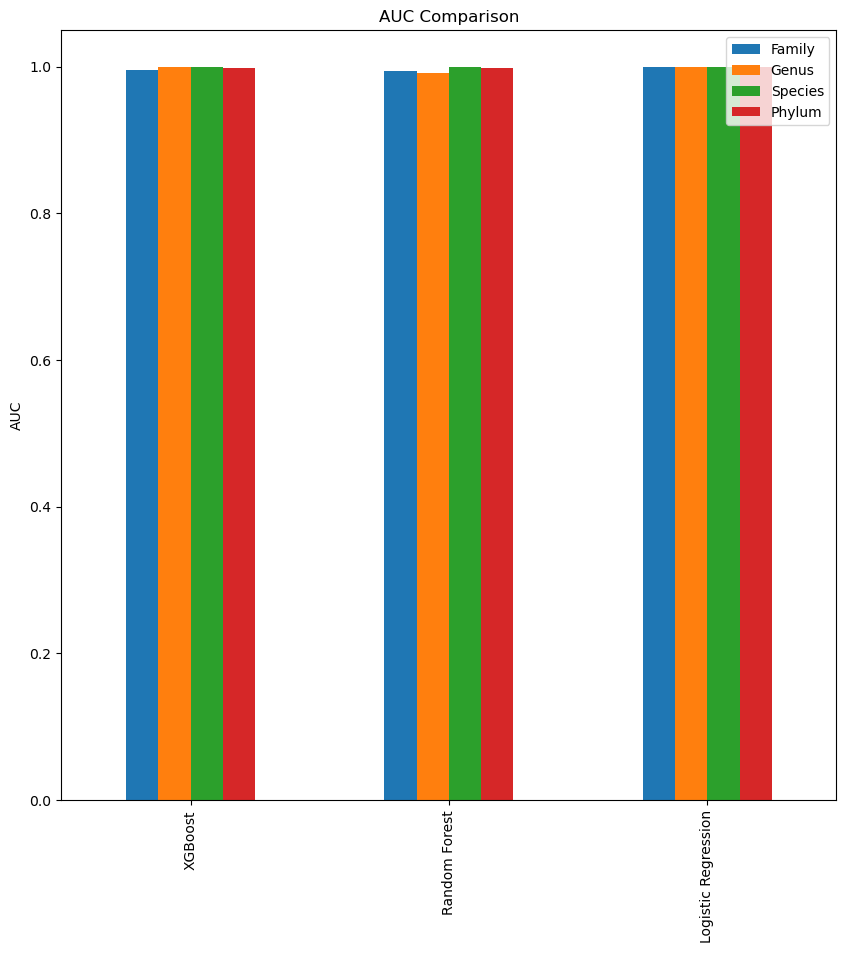

In [81]:
# plot auc comparison


data = {'Family': [auc_XGB_fam, auc_RF_fam, auc_lr_fam],
        'Genus': [auc_XGB_genus, auc_RF_genus, auc_lr_genus],
        'Species': [auc_XGB_spec, auc_RF_spec, auc_lr_spec],
        'Phylum': [auc_XGB_phylum, auc_RF_phylum, auc_lr_phylum]}

df = pd.DataFrame(data)

# plot
df.plot(kind='bar', figsize=(10, 10))
plt.xticks(np.arange(3), ('XGBoost', 'Random Forest', 'Logistic Regression'))
plt.ylabel('AUC')
plt.title('AUC Comparison')
plt.show()